# Practical 2

**Group composition**: 
- Lucie-Marie BOSCHIAN CAMPANER &bull; [lucie-marie.boschiancampaner@ensiie.fr](mailto:lucie-marie.boschiancampaner@ensiie.fr)
- Khalil BATTIKH &bull; [khalil.battikh@ensiie.fr](mailto:khalil.battikh@ensiie.fr)
- Lucas RODRIGUEZ &bull; [lucas.rodriguez@ensiie.fr](mailto:lucas.rodriguez@ensiie.fr)

**Group ID**: 12

**Author**: *Lucas RODRIGUEZ*

## First steps

In [358]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import missingno as msno
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# Setting up a fixed random seed for experiment purposes
np.random.seed(1)

The chosen dataset is the following : **Air Quality**.

- Link of the dataset description: https://archive.ics.uci.edu/ml/datasets/Air+Quality
- Direct link to the dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/00360/


**Selected strategy** : The given dataset offers a lot of features and observations. However, a lot of irregularities have been detected by us. We have to perform heavy transformations on the dataset using pre-processing operations.

To do so, we can first think about using Numpy, for matrix-based manipulations. However, we have decided to use Pandas to deal with tabular data more easily then convert the output version into a Numpy matrix as input for our NN model.

In [212]:
# Importing the given dataset
file_name = "data/AirQualityUCI.csv"
df = pd.read_csv(filepath_or_buffer=file_name,
                sep=";",
                #index_col="Date",
                na_values=np.nan,
                decimal=",") # Floating point separator for implicit casting

# Making a deep copy for safety reason
df_initial = df.copy(deep=True)

In [213]:
# Some informations about the different columns composing the csv file
df.info()

# General shape of the DataFrame
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


(9471, 17)

The dataset initially contains 9471 rows and 16 columns.

### Dataset description

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value. 


---

0. Date (format: DD/MM/YYYY)
1. Time (format: HH.MM.SS)
2. True hourly averaged concentration CO in $\text{mg}/\text{m}^3$ (reference analyzer) 
3. PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted) 
4. True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) 
5. True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) 
6. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted) 
7. True hourly averaged NOx concentration in ppb (reference analyzer) 
8. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
9. True hourly averaged NO2 concentration in microg/m^3 (reference analyzer) 
10. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted) 
11. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) 
12. Temperature (in °C)
13. Relative Humidity (%) 
14. AH: Absolute Humidity


### Dataset references & License



Saverio De Vito (saverio.devito@enea.it), ENEA - National Agency for New Technologies, Energy and Sustainable Economic Development

In [214]:
# A quick overview of the dataset structure
df.head(8)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
5,10/03/2004,23.00.00,1.2,1197.0,38.0,4.7,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848,NaN,NaN
6,11/03/2004,00.00.00,1.2,1185.0,31.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603,NaN,NaN
7,11/03/2004,01.00.00,1.0,1136.0,31.0,3.3,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702,NaN,NaN


## Data pre-processing

### Drop duplicates

We can handle duplicate rows by using the following instruction


In [215]:
df.drop_duplicates(inplace=True) # we keep the "keep" argument to its default value : "first"
df.shape

(9358, 17)

We have successfully eliminated $9471 - 9347 = \fbox{124}$ rows (especially, most of them were rows filled of NaN values (see next section). 

**Remark** : Most of them have been removed thanks to the `drop_duplicate` operation. However, we still have a remaining row at the end. We remove it.

In [216]:
df.dropna(how="all", inplace=True)
df.shape

(9357, 17)

In [217]:
# We first determine for each column, the number of different values in this column by using the following Pandas method
df.nunique()

Date              391
Time               24
CO(GT)             97
PT08.S1(CO)      1042
NMHC(GT)          430
C6H6(GT)          408
PT08.S2(NMHC)    1246
NOx(GT)           926
PT08.S3(NOx)     1222
NO2(GT)           284
PT08.S4(NO2)     1604
PT08.S5(O3)      1744
T                 437
RH                754
AH               6684
Unnamed: 15         0
Unnamed: 16         0
dtype: int64

### Drop useless columns

We can easily see, thanks to the previous cell, that the last two columns are completely empty

$\Longrightarrow$ We immediately remove them.

In [218]:
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Columns already removed.")
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139


### Customizing the inner structure of the dataset

We observe that `Date` and `Time` are `object`-typed. Since we want to perform a regression model on our data, we want to explain the target variable with the widest subset of possible features.



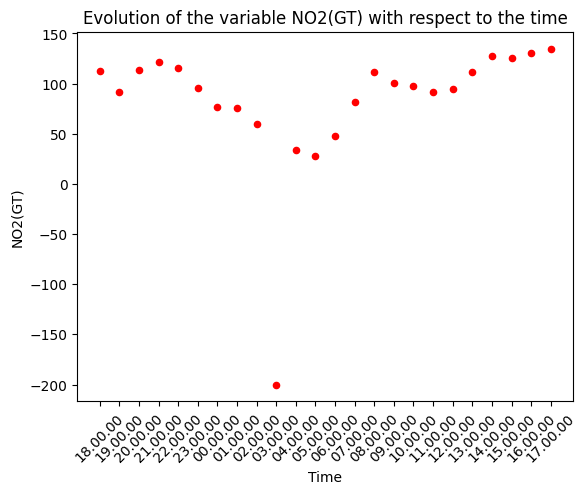

In [219]:
_ = df[0:24].plot.scatter("Time", "NO2(GT)", 
                      rot=45, 
                      color="red"
                     )
_ = plt.title("Evolution of the variable NO2(GT) with respect to the time")

We can see that, on the scale of only one day, the evolution of concentration of some substances is clearly highlighted here.

We have:
- `Date`: DD/MM/YYYY
- `Time`: HH.MM.SS (but the frequency of observation is an hourly-basis.



We also observe that the date range goes from 10/03/2004 to 03/04/2005; we can remove the year detail and only encode the month as follows:
- March 2004 $\longrightarrow 0$
- April 2004 $\longrightarrow 1$ 
- ...

As shown in the below figures, we see that there is no clear reason in keeping the days into the dataset; we remove them.

<img src="img/cal1.png" width=600>

<img src="img/cal2.png" width=600>


In fact, there is no need to keep the days because of the combination of the record id (represented by the index of the row) and the hours.


To conclude, we have decided to keep the months (as an encoded field) and the hours (the minutes and seconds dedicated fields are empty because of the hourly refresh time frequency.

In [220]:
# Creating the month column
get_month = lambda x:x.split("/")[1][1] if x.split("/")[1][0] == '0' else x.split("/")[1]
df["Month"] = df["Date"].apply(get_month)
df["Month"] = pd.to_numeric(df["Month"])

In [221]:
# Creating the hour column
get_hour = lambda x:x.split(".")[0][0] if x.split(".")[0][1] == '0' else x.split(".")[0]
df["Hour"] = df["Time"].apply(get_hour)
df["Hour"] = pd.to_numeric(df["Hour"])

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Month          9357 non-null   int64  
 16  Hour           9357 non-null   int64  
dtypes: float64(13), int64(2), object(2)
memory usage: 1.

In [244]:
# Dropping the column Date and Time
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['Date', 'Time'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Columns already removed.")
df

Columns already removed.


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,Hour
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,3,18
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,3,19
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,3,2
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,3,21
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,4,1
9353,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,4,11
9354,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,4,12
9355,2.1,1003.0,NaN,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,4,13


### Thresholding the values ($-200 = \text{NaN}$)

We have remarked the following highlight from the dataset webpage:
> Missing values are tagged with -200 value. 

We have to replace all values under $-200$ by a NaN item; we will then deal with them in the next section:

In [254]:
columns_float = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH']
df[df[columns_float] <= -200] = np.nan

### Handling missing values (NaN)

In order to train and validate our model, we cannot tolerate the presence of NaN values within the input dataset; we have to remove all of them.

To have a graphical confirmation, we can produce the two bar plots below showing the "distribution" of the missing values among our dataset.

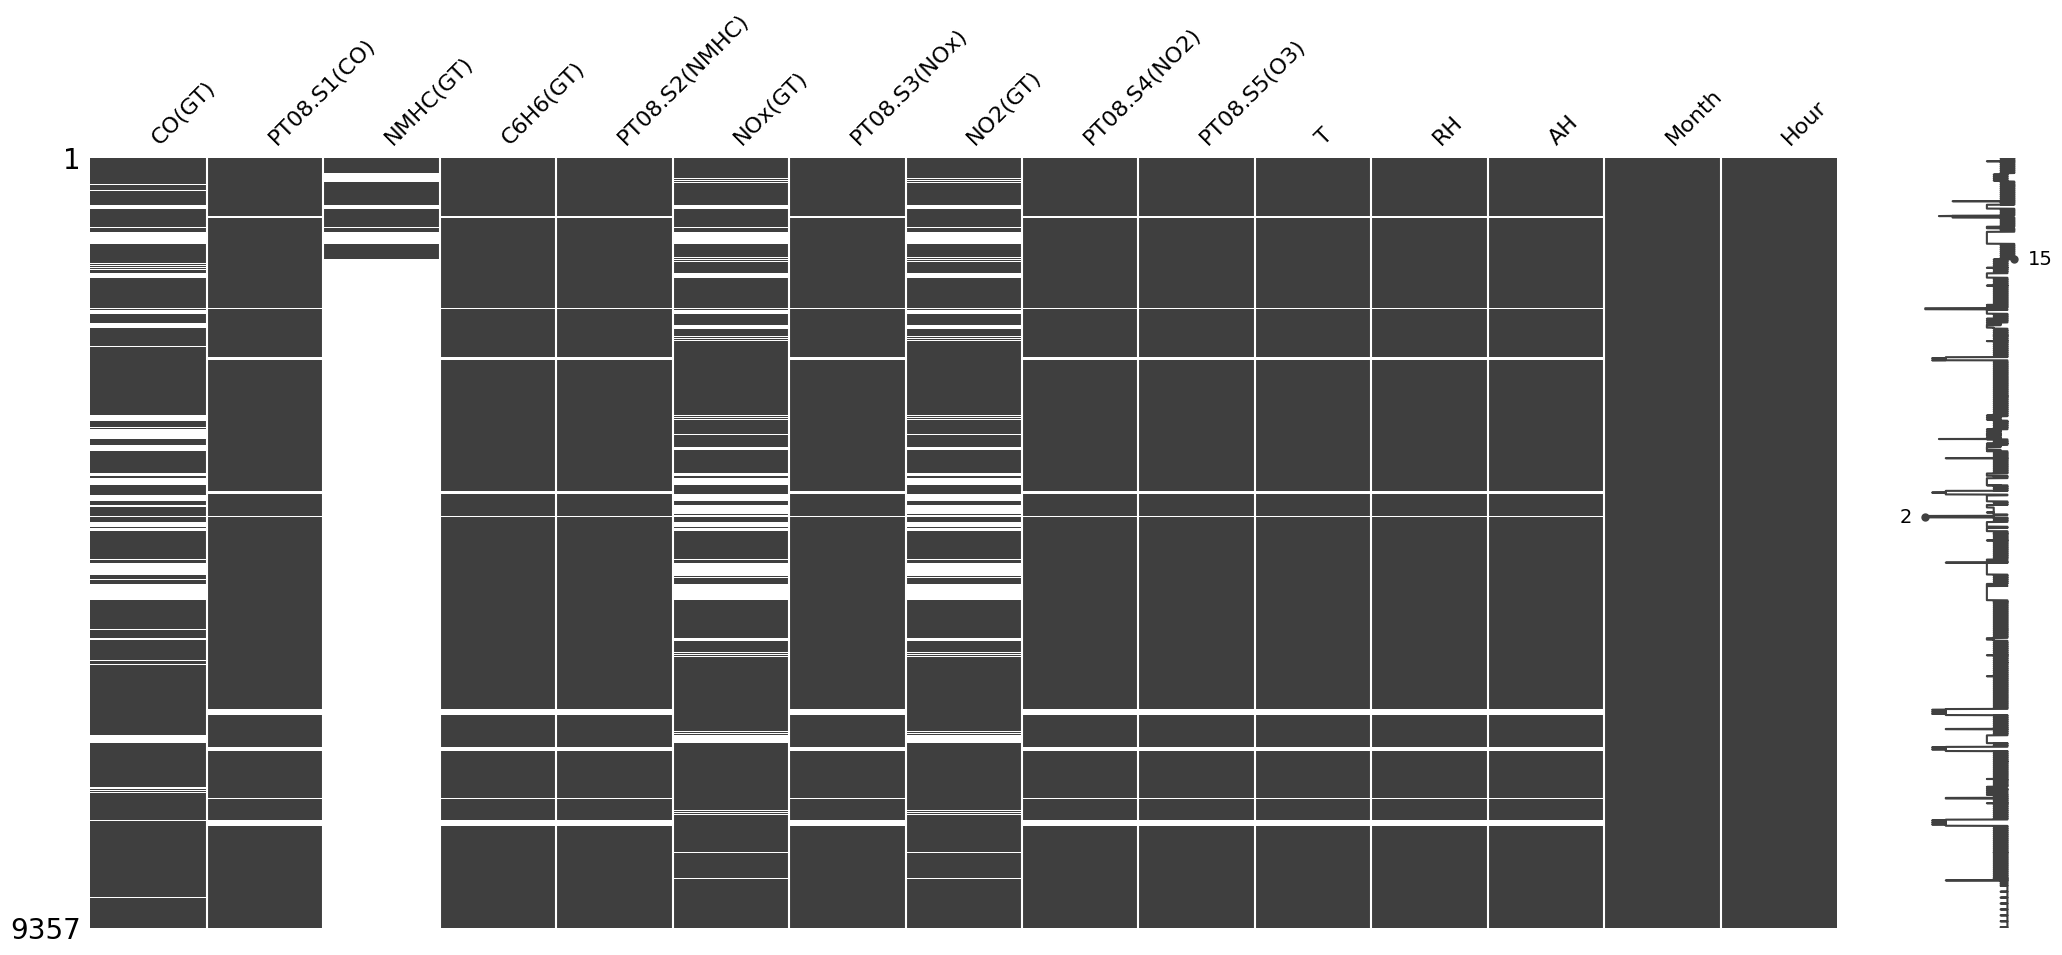

In [255]:
_ = msno.matrix(df)

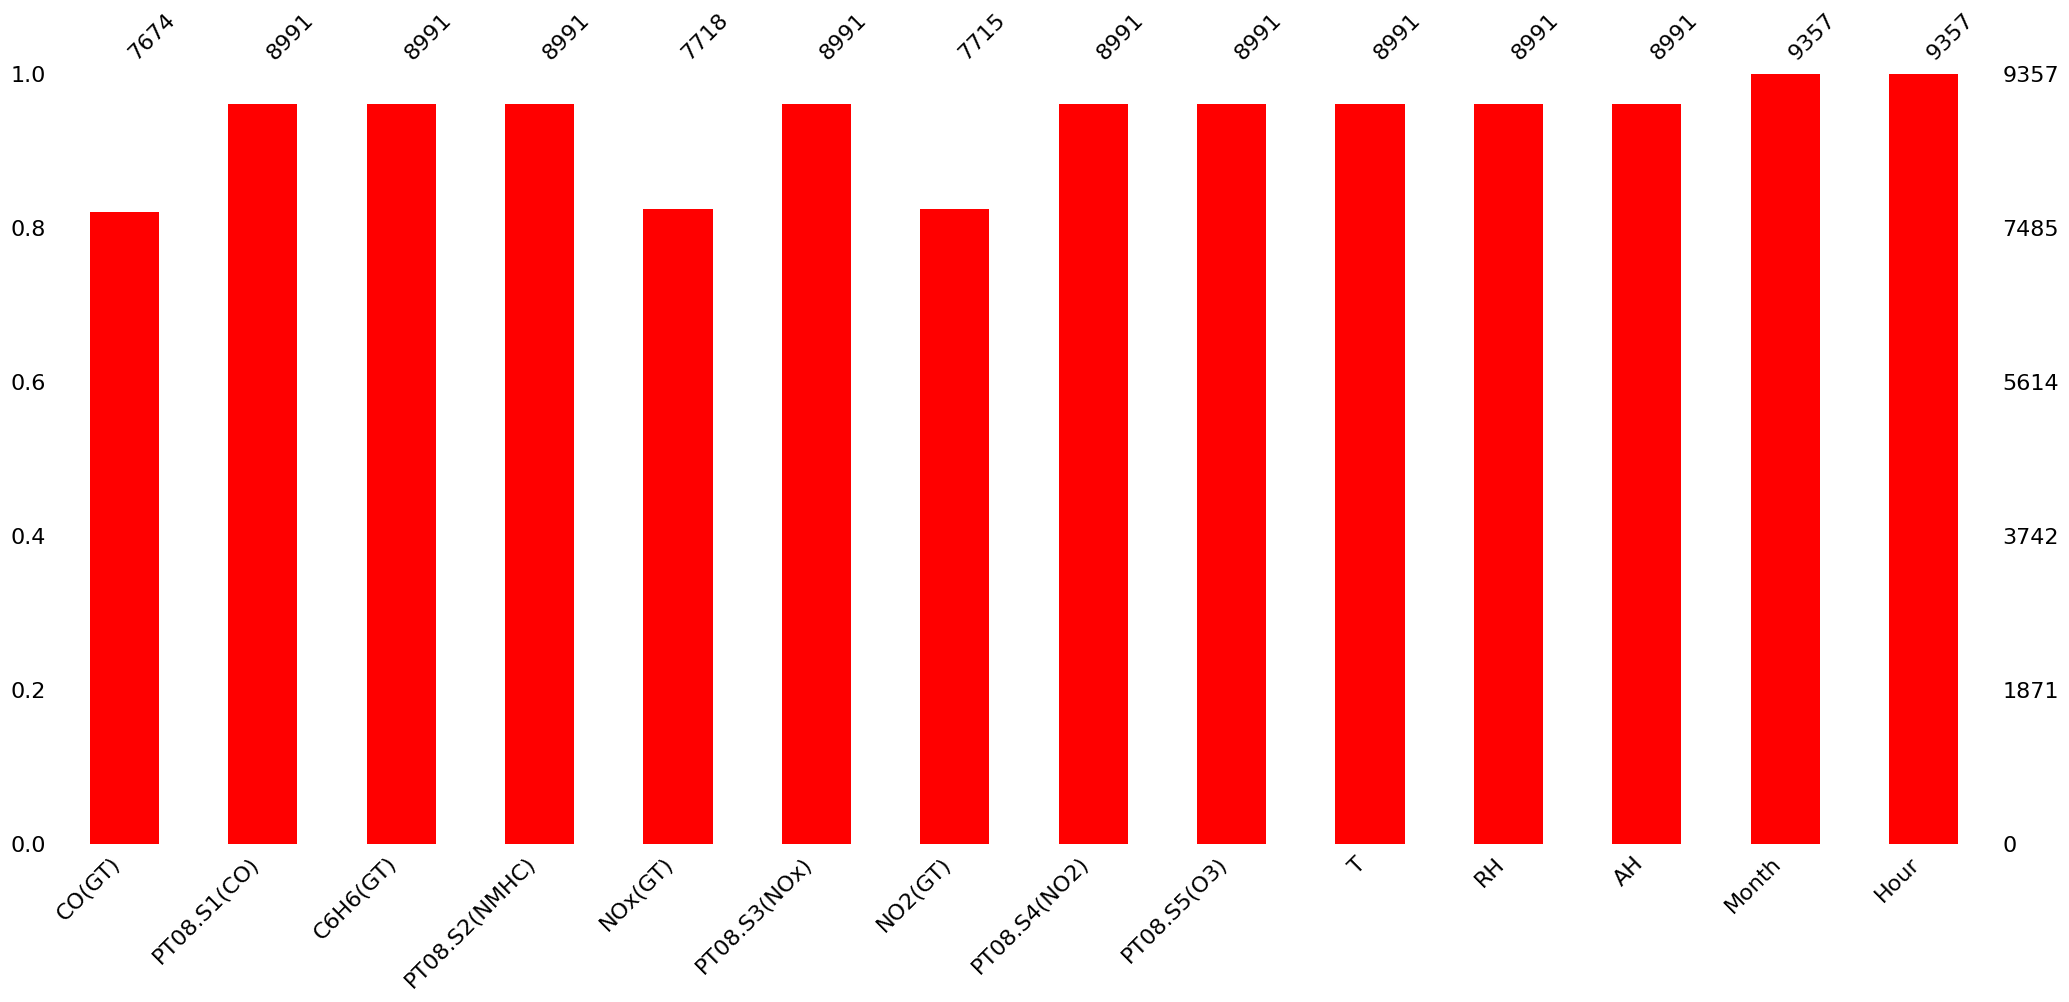

In [260]:
_ = msno.bar(df, color="red")

The feature : **`NMHC(GT)`** has a high proportion of NaN elements 

$\Longrightarrow$ This column cannot provide meaningful conclusion on the selected target.

$\Longrightarrow$ We decide to remove the column **`NMHC(GT)`**.

In [261]:
# Dropping the column NMHC(GT)
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['NMHC(GT)'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Column already removed.")
df

Column already removed.


,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,Hour
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,3,18
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,3,19
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,3,2
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,3,21
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,4,1
9353,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,4,11
9354,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,4,12
9355,2.1,1003.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,4,13


The other columns have a proportion of non-NaN greater than $80 \ \%$, which contains most of the information of the corresponding feature; we can replace these NaN values by a significant statistical indicator such as : median or mean value.

In [283]:
# Removing the NMHC(GT) column
try:
    columns_float.remove('NMHC(GT)')
except ValueError:
    pass
columns_float
for c in columns_float:
    df[c].fillna(df[c].mean(), inplace=True) # or .median()

In [279]:
# Computing the percentage of remaining missing values
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

CO(GT)           0.0
PT08.S1(CO)      0.0
C6H6(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
Month            0.0
Hour             0.0
dtype: float64

We're good to go !

### Final steps

In [370]:
# Saving the pre-processed output DataFrame within an intermediary file
df.to_csv(path_or_buf="data/clean_data.csv",
         sep=";",
         header=True)

In [371]:
# Statistical description of the final dataset
df.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
CO(GT),9357.0,2.153,1.316,0.100,1.200,2.153,2.600,11.900
PT08.S1(CO),9357.0,1099.833,212.792,647.000,941.000,1075.000,1221.000,2040.000
NOx(GT),9357.0,246.897,193.427,2.000,112.000,229.000,284.000,1479.000
PT08.S3(NOx),9357.0,835.494,251.744,322.000,666.000,818.000,960.000,2683.000
NO2(GT),9357.0,113.091,43.921,2.000,86.000,113.091,133.000,340.000
PT08.S4(NO2),9357.0,1456.265,339.368,551.000,1242.000,1456.265,1662.000,2775.000
T,9357.0,18.318,8.658,-1.900,12.000,18.300,24.100,44.600
RH,9357.0,49.234,16.975,9.200,36.600,49.234,61.900,88.700
AH,9357.0,1.026,0.396,0.185,0.746,1.015,1.296,2.231
Month,9357.0,6.310,3.438,1.000,3.000,6.000,9.000,12.000


### Handling high-correlated data

Linear regression cannot perform a good fitting process with highly-correlated features.
Given a specific threshold, we will remove the most correlated variables in order to obtain consistent results.

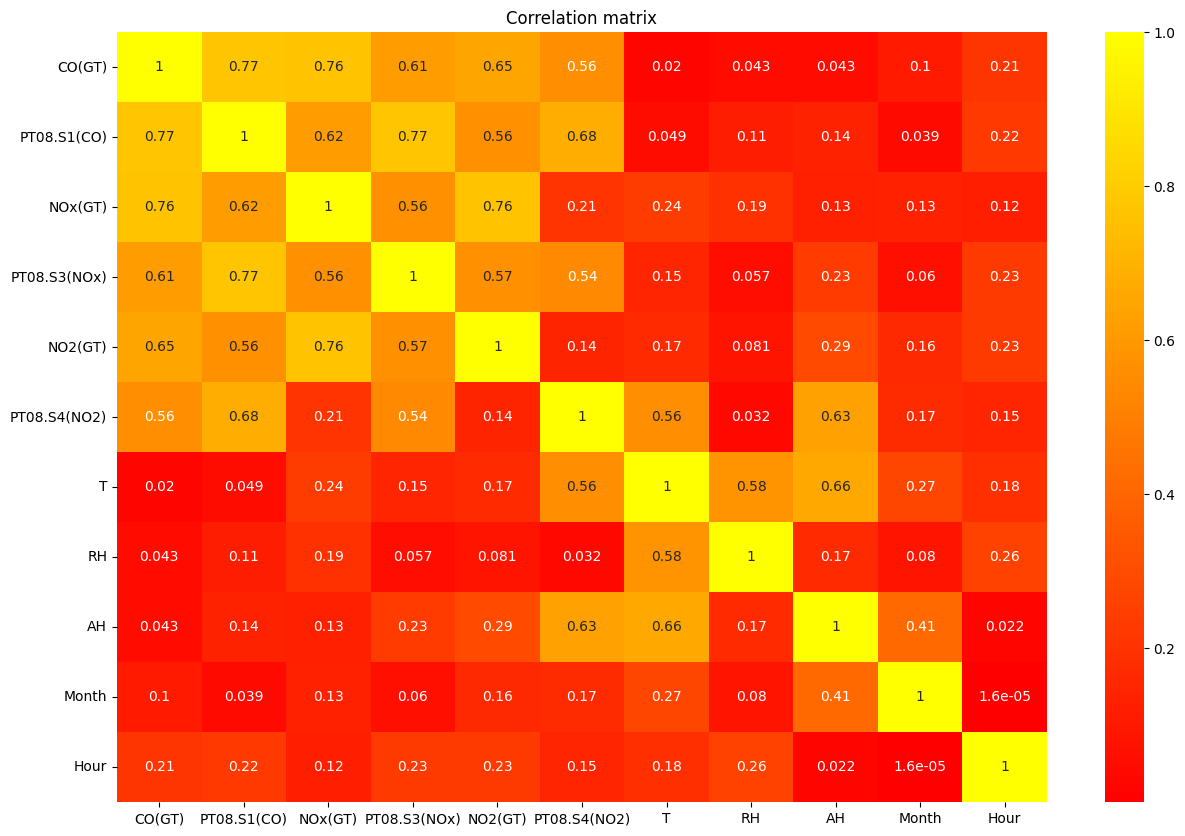

In [373]:
# Computing and plotting the correlation matrix of the final dataset
plt.figure(figsize=(15, 10))
correlation_matrix = df.corr().abs()
sns.heatmap(correlation_matrix, annot=True, cmap="autumn")
plt.title("Correlation matrix")
plt.show()

In [379]:
# Select upper triangle of correlation matrix (because it's a symmetric matrix)
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
#print(upper)

# Find features with correlation greater than a fixed threshold
HIGH_CORRELATION_THRESHOLD = 0.88
to_drop = [column for column in upper.columns if any(upper[column] > HIGH_CORRELATION_THRESHOLD)]

# Drop selected features
try:
    if len(to_drop) != 0:
        print(f"We drop the following variables: {to_drop}")
        df.drop(to_drop, axis=1, inplace=True)
        print("Removing high-correlated columns")
    else:
        print("High-correlated features have already been removed by the user.")
except:
    print("High-correlated features have already been removed by the user.")

High-correlated features have already been removed by the user.


In [380]:
# (Obsolete) Alternative method to find pairs of heavy-correlated variables
#c = df.corr().abs()
#s = c.unstack()
#so = s.sort_values(kind="quicksort")
#so.drop(so)
#HIGH_CORRELATION_THRESHOLD = 0.85
#so[(so != 1.0) & (so > HIGH_CORRELATION_THRESHOLD)].drop_duplicates().keys()

We remark the upper left-hand corner contains highly-correlated variables.

### Handling outliers

<p style="color:red"> 
    <b>WARNING</b>: This step has to be performed <b>RIGHT AFTER</b> the train/test/validation split <b>AND ONLY</b> on the train set.
</p>

In order to check the presence of outliers within our dataset, we analyze the box-plot of each column.

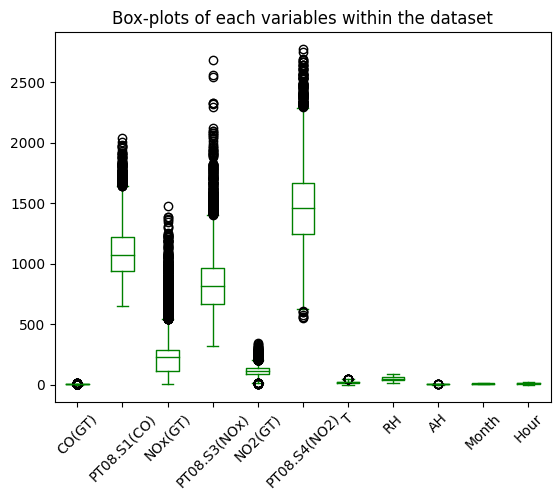

In [389]:
df.plot(kind="box",
       title="Box-plots of each variables within the dataset",
       color="green", xlabel=None)
_ = plt.xticks(rotation=45)

We can observe a lot of outliers, in particular for `PT08.S1(CO)`, `NOx(GT)`, and `PT08.S3(NOx)`and `PT08.S4(NO2)`.

At first sight, we wanted to perform some data pre-processing on the outliers. Our first track was to implement the **Winsorize method** which rescales the observations and tries to replace the outliers by "normal values".

However, since we don't want to facilitate **over-fitting** potential behaviors and as we also want to introduce noise in the coming steps within the feedforwarding step, we do not pursue on this track.

/var/folders/w1/2mtn71gj3cs0yzx6vnfrh7wm0000gn/T/ipykernel_32234/1168358797.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(df[df.columns[i*2+j]], ax=ax[i][j], color="blue")
/var/folders/w1/2mtn71gj3cs0yzx6vnfrh7wm0000gn/T/ipykernel_32234/1168358797.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

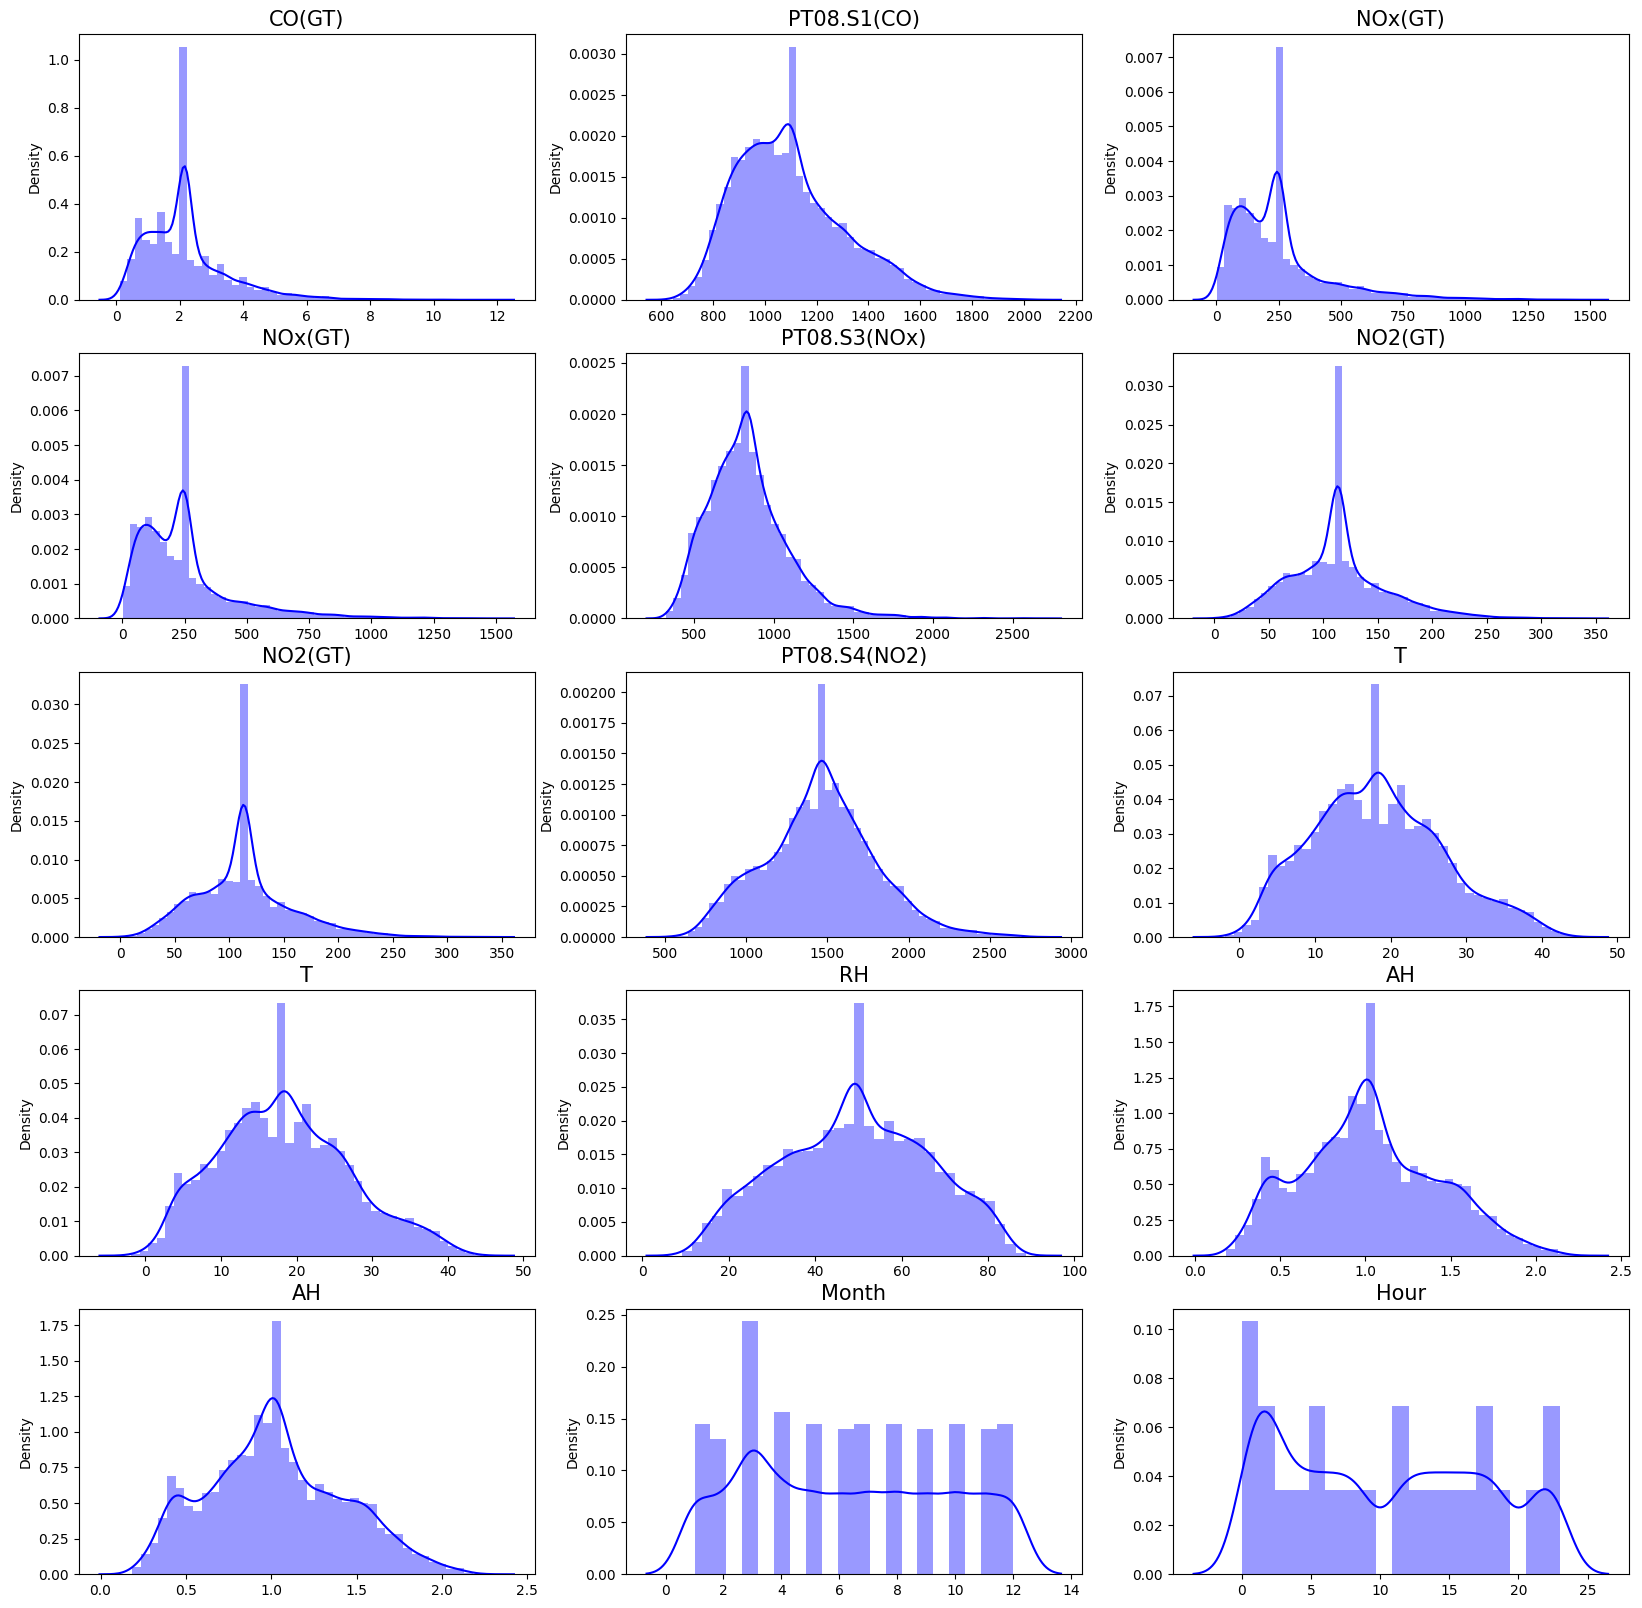

In [391]:
# Plotting distribution plots for each column
fig, ax = plt.subplots(5, 3, figsize=(20, 20))
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        g = sns.distplot(df[df.columns[i*2+j]], ax=ax[i][j], color="blue")
        g.set(xlabel=None)
        g.set_title(df[df.columns[i*2+j]].name, fontsize = 15)



### Creation of train/test datasets

As a reminder, we have chosen:
- $Y$ = target
- $X$ = features

In [356]:
X = df.copy()
Y = X.pop("CO(GT)")
#Y.astype("float")

In [359]:
# Size setting
size_sample_test = 0.2

# Creation of training and testing dataset + Shuffling
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = size_sample_test)
X_train.sample(frac=1)
X_test.sample(frac=1)

,PT08.S1(CO),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),T,RH,AH,Month,Hour
8426,1367.000000,551.000000,485.000000,265.000000,1492.000000,6.300000,74.900000,0.71870,2,2
6760,1099.833166,937.000000,835.493605,164.000000,1456.264598,18.317829,49.234201,1.02553,12,1
6514,828.000000,146.000000,1074.000000,64.000000,1103.000000,11.900000,71.400000,0.99210,12,4
4267,1062.000000,246.896735,729.000000,113.091251,1459.000000,37.100000,21.200000,1.31070,9,13
8509,817.000000,89.000000,1378.000000,66.000000,732.000000,2.500000,52.700000,0.39080,2,7
...,...,...,...,...,...,...,...,...,...,...
7356,1047.000000,115.000000,863.000000,75.000000,1147.000000,12.000000,69.200000,0.96970,1,6
3737,953.000000,83.000000,868.000000,109.000000,1573.000000,35.700000,29.000000,1.67160,8,11
8267,872.000000,36.000000,1249.000000,35.000000,794.000000,6.900000,48.100000,0.47960,2,5
4598,903.000000,176.000000,1035.000000,81.000000,1317.000000,20.700000,49.700000,1.19700,9,8


TODO : check the document

Hyperparameters whose effect I wan to know you tested include :
- $\#$ of layers
- $\#$ of neurons
- learning rate
- regularization
- activation functions
- impact of normalizing your dataset
- impact of noising your dataset (after normalization)

$\mu$, $\sigma$ output predicting what Gaussian distribution the output belongs to if truly Gaussian

99% of the outputs between 

## NN model